Задача:
предсказать получение пиццы, человеком оставившим запрос на сайте Reddit в сообществе Random Acts of Pizza
- Исходные данные файл train.json
- Тестовые данные test.json
- Оценка качества по метрике area under the ROC curve
- Образец файла для выгрузки на Каггл

In [1]:
from contextlib import redirect_stdout

import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

from sklearn import preprocessing
from sklearn import ensemble
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

Согласно приложенного к данным документа http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf важными факторами является содержание обращения (текстовые признаки) раскрывающее причины просьбы, а именно:
- наличие слов вежливости;
- упоминание семьи;
- ситуация на работе;
- упоминание денег;
- благодарность пользователя;
- упоминание еды;
- упоминание времени;
- отсутствие ругательств.

Исходя из этого формируются словари для перекодирования текстовых признаков в цифровые.

In [2]:
negative_list = ['give me a break',
 'bitch',
 'fuck off',
 'son of a bitch',
 'fucking shit',
 'dumb',
 'what the fucking hell',
 'jerk',
 'poop',
 'prick',
 'sucking',
 'fucking idiot',
 'faggot',
 'assholes',
 'loser',
 'homo',
 'sucked',
 'fuck up',
 'asscrack',
 'grammar nazi',
 'crap',
 'retard',
 'ass',
 'stupid',
 'coz',
 'slut',
 'stupid',
 'dick',
 'asses',
 'fucked',
 'shit',
 'asshole',
 'nerd',
 'idiot',
 'no way',
 'sucks',
 'fuck around',
 'gay',
 'motherfucker',
 "fuck",
 'fucking',
 'fool',
 'nigger',
 'freak',
 'fucking',
 'noob',
 'hooker',
 'bumfuck',
 'cunt',
 'kiss my ass',
 'douchebag',
 'fuck you',
 'innit',
 'whore',
 'damn',
 'dafaq',
 'fool',
 'shit',
 'fucking',
 'bastard',
 'pussy',
 'are you nuts',
 'ass',
 'fuck',
 'bullshit',
 'sucker',
 'bastards',
 'screw it',
 'fuck with']

In [3]:
politeness_list = ['thanlful',
 'pardon',
 'excuse',
 'kindfavor',
 'blessing',
 'thanx',
 'could',
 'kind',
 'hope',
 'anyone',
 'thankful',
 'help',
 'course',
 'certainly',
 'thakyou',
 'thankfully',
 'sorry',
 'slight',
 'advance',
 'thank you',
 'thx',
 'slightly',
 'wonderful',
 'hope',
 'reading',
 'perhaps',
 'anything',
 'would',
 'bless',
 'seem',
 'grateful',
 'thank',
 'bit',
 'everyone',
 'blessed',
 'excuse',
 'wonderfully',
 'blessings',
 'thanks',
 'blessins',
 'thankyou']

In [4]:
reciprocity_list = ['share the love',
 'repay in kind',
 'return a favor',
 'return kindness',
 'repay the kindness',
 'pay it forward',
 'share kindness']

In [5]:
driver_list = [
 'burger',
 'burgers',
 'yogurt',
 'someone',
 'couple',
 'help',
 'rice',
 'luck',
 'anything',
 'ramen',
 'today',
 'food',
 'school',
 'pizza',
 'favor',
 'end',
 'stamp',
 'grocery',
 'vegetables',
 'vegetable',
 'vegitarian',
 'vegetarians',
 'vegans',
 'vegan',
 'house',
 'anyone']

In [6]:
family_list = ['wife',
 'boyfriend',
 'boyfriendly',
 'boyfriends',
 'boy',
 'boys',
 'brother',
 'brothers',
 'dad',
 'mum',
 'husband',
 'parent',
 'son',
 'mother',
 'daughter',
 'mom',
 'family',
 'father',
 'parents']

In [7]:
money_list = ['bills',
 'check',
 'buy',
 'budget',
 'cash',
 'payed',
 'budgeting',
 'ﬁnancial',
 'spent',
 'paycheck',
 'budgeted',
 'credit',
 'current',
 'money',
 'bucks',
 'bill',
 'unpaid',
 'rent',
 'loan',
 'deposit',
 'poor',
 'visa',
 'account',
 'due',
 'dollar',
 'paid',
 'broke',
 'bank',
 'still',
 'usd',
 'dollars']

In [8]:
time_list = ['tonight',
 'time',
 'week',
 'month',
 'Friday',
 'today',
 'day',
 'now',
 'after',
 'till',
 'evening',
 'when',
 'year',
 'tomorrow',
 'tonight',
 'hour',
 'years',
 'before',
 'long',
 'until',
 'yesterday',
 'morning',
 'soon',
 'past',
 'ﬁrst',
 'while',
 'never',
 'next',
 'last',
 'ago',
 'night']

In [9]:
job_list = ['employment',
 'ﬁred',
 'job',
 'interview',
 'work',
 'hired',
 'hire',
 'unemployment']

In [10]:
student_list = ['studying',
 'project',
 'study',
 'tuition',
 'student',
 'ﬁnals',
 'college',
 'semester',
 'university',
 'class',
 'school',
 'roommate',
 'dorm']

In [11]:
craving_list = ['movie',
 'celebrate',
 'games',
 'beer',
 'drunk',
 'celebrating',
 'friend',
 'crave',
 'invite',
 'boyfriend',
 'invited',
 'girlfriend',
 'date',
 'drinks',
 'birthday',
 'wasted',
 'craving',
 'party',
 'game']

In [12]:
data_path = 'Data//'
train_data = 'train.json'
test_data = 'test.json'

Формируем дополнительные признаки на основе имеющихся данных с учетом различий между тестовыми и обучающими данными

In [13]:
def get_data(data_path, train_data):
    return data_path + train_data


def make_frame(train_url):
    df = pd.read_json(train_url)
    return df

In [14]:
def group_selector(train_df, k=0):
    neg_bag_of_words = list()
    neg_count = dict()
    for ind in train_df[train_df.requester_received_pizza == k].index:
        neg_bag_of_words += train_df.requester_subreddits_at_request[ind]
        for word in train_df.requester_subreddits_at_request[ind]:
            if word in neg_count:
                neg_count[word] += 1
            else:
                neg_count[word] = 1
    return neg_count


def unique_group(train_df):
    neg_count = group_selector(train_df, k=0)
    res_count = group_selector(train_df, k=1)
    unique_group = res_count.keys() - neg_count.keys()
    return unique_group

In [15]:
#Какая длинна текста с просьбой о пицце
def text_length(raw):
    if len(raw.split()) > 1:

        return len(raw.split())
    else:
        return 0

#Есть ли в тексте фотографии
def photos(raw):
    return raw.count('http://i.imgur.com/')

#Был ли отредактирован текст просителем пиццы
def edited_text(raw):
    word_list = raw.split()
    if 'EDIT' in word_list:
        return 1
    else:
        return 0

#На основе словарей считем число вхождений различных групп слов
def text_produce(raw, terms_list):
    result = 0
    word_list = raw.lower()
    for item in set(terms_list):
        if item in word_list:
            result += 1
    if result > 0:
            return result
    else:
        return 0

In [16]:
#загружаем данные из файлов тренировочные и тестовые    
train_url = get_data(data_path, train_data)
train_df = make_frame(train_url)

test_url = get_data(data_path, test_data)
test_df = make_frame(test_url)

In [17]:
train_df.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

In [18]:
test_df.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [19]:
#Отбираем из тренировочных данных признаки/колонки имеющиеся в тестовых
for col in train_df.columns:
    if col != 'requester_received_pizza':
        if col not in test_df.columns:
            del train_df[col]

In [20]:
train_df.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request', 'requester_received_pizza',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [21]:
#Отбираем группы в которых находятся только получатели пиццы в обучающей выборке
positive_result_groups = unique_group(train_df)
print('Уникальных групп на сайте у получателей пиццы', len(positive_result_groups))

Уникальных групп на сайте у получателей пиццы 1072


In [22]:
#Если указано имя дарителя пиццы ставим 1, если нет 0
train_df.loc[train_df.giver_username_if_known == 'N/A', 'giver_username_if_known'] = 0
train_df.loc[train_df.giver_username_if_known != 0, 'giver_username_if_known'] = 1

In [23]:
#Переводим в из объекта в цифровой тип
train_df['giver_username_if_known'] = pd.to_numeric(train_df['giver_username_if_known'], errors='coerse')
#Переводим из True-False в 1-0 по условиям задачи
train_df['requester_received_pizza'] = (train_df['requester_received_pizza'] == True).astype(int)

In [24]:
#Вместо двух колонок времени, формируем одну - есть "ошибка" в настройках компьютера пользователя или нет
train_df['time_delta'] = train_df['unix_timestamp_of_request'] - train_df['unix_timestamp_of_request_utc']
#Удаляем ненужные колонки времени
remove = ['unix_timestamp_of_request', 'unix_timestamp_of_request_utc']
for rem in remove:
    del train_df[rem]

In [25]:
#Размечаем группы в которых находятся только получатели пиццы в обучающей выборке
for gr in positive_result_groups:
    train_df[gr] = 0
for ind in train_df[train_df.requester_received_pizza == 1].index:
    for word in train_df.requester_subreddits_at_request[ind]:
        if word in positive_result_groups:
            train_df.at[ind, word] = 1

In [26]:
#Формируем дополнительные признаки на основе имеющегося текста из 'request_text_edit_aware'
train_df['text_length'] = train_df['request_text_edit_aware'].apply(lambda x: text_length(x))
train_df['title_length'] = train_df['request_title'].apply(lambda x: text_length(x))
train_df['photos_number'] = train_df['request_text_edit_aware'].apply(lambda x: photos(x))
train_df['text_was_edited'] = train_df['request_text_edit_aware'].apply(lambda x: edited_text(x))
train_df['negative_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, negative_list))
train_df['politeness_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, politeness_list))
train_df['reciprocity_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, reciprocity_list))
train_df['driver_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, driver_list))
train_df['job_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, job_list))
train_df['money_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, money_list))
train_df['student_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, student_list))
train_df['craving_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, craving_list))
train_df['time_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, time_list))
train_df['family_words'] = train_df['request_text_edit_aware'].apply(lambda x: text_produce(x, family_list))

In [27]:
#Определяем числовые колонки и формируем тренировочный фрейм для работы
numerical_columns   = [c for c in train_df.columns if train_df[c].dtype.name != 'object']
df_res = train_df[numerical_columns]

In [28]:
#Удаляем метку класса из тренировочного фрейма

y = df_res['requester_received_pizza']
del df_res['requester_received_pizza']

In [29]:
#Формируем функцию проверки классификаторов
def classifiers_evaluation(df_res, y):

    classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    MLPClassifier(),
    SGDClassifier(loss='log', max_iter=1000),
    LogisticRegressionCV()]

    log_cols = ["Classifier", "ROC_AUC score"]
    log = pd.DataFrame(columns=log_cols)

    quantile = preprocessing.QuantileTransformer()
    X = quantile.fit_transform(df_res)

    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

    acc_dict = {}

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for clf in classifiers:
            name = clf.__class__.__name__
            clf.fit(X_train, y_train)
            train_predictions = clf.predict(X_test)
            acc = roc_auc_score(y_test, train_predictions)


            if name in acc_dict:
                acc_dict[name] += acc
            else:
                acc_dict[name] = acc

    for clf in acc_dict:
        acc_dict[clf] = acc_dict[clf] / 10.0
        log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
        log = log.append(log_entry)

    print(log)

    plt.xlabel('ROC_AUC score')
    plt.title('Classifier ROC_AUC score')
    sns.set(rc={'figure.figsize':(18,12)})
    sns.set_color_codes("muted")
    sns.barplot(x='ROC_AUC score', y='Classifier', data=log, color="b")

C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-p

                      Classifier  ROC_AUC score
0           KNeighborsClassifier       0.634487
0                            SVC       0.500000
0         DecisionTreeClassifier       0.648828
0         RandomForestClassifier       0.644355
0             AdaBoostClassifier       0.679478
0     GradientBoostingClassifier       0.672767
0                     GaussianNB       0.704545
0     LinearDiscriminantAnalysis       0.599672
0  QuadraticDiscriminantAnalysis       0.703535
0             LogisticRegression       0.666733
0                  MLPClassifier       0.682376
0                  SGDClassifier       0.665710
0           LogisticRegressionCV       0.677831


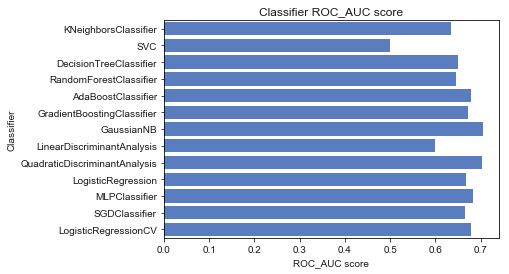

In [30]:
#Проверяем классификаторы на эффективность
classifiers_evaluation(df_res, y)

In [31]:
#Формируем ансамбль
def soft_voting(df_res, y):
    print('\n')
    print('SOFT VOTING')

    quantile = preprocessing.QuantileTransformer()
    df_res = quantile.fit_transform(df_res)

    clf1 = ensemble.AdaBoostClassifier()
    clf2 = MLPClassifier()
    clf3 = ensemble.GradientBoostingClassifier()
    clf4 = SGDClassifier(loss='log', max_iter=1000)
    clf5 = LogisticRegression()
    clf6 = LogisticRegressionCV()
    clf7 = QuadraticDiscriminantAnalysis()
    clf8 = GaussianNB()
    clf9 = LinearDiscriminantAnalysis()
    clf10 = SVC(probability=True)
    eclf = VotingClassifier(estimators=[('ada', clf1), ('mlpc', clf2),
                                        ('gbs', clf3), ('sgdc', clf4),
                                        ('lgr', clf5), ('lrcv', clf6),
                                        ('qda', clf7), ('gnb', clf8),
                                        ('lda', clf9), ('svc', clf10)],
                                voting='soft', weights=[1,1,1,1,1,1,1,1,1,1])

    for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, eclf],
                          ['AdaBoostClassifier', 'MLPClassifier',
                           'GradientBoosting', 'SGDClassifier',
                           'LogisticRegression', 'LogisticRegressionCV',
                           'QuadraticDiscriminantAnalysis', 'GaussianNB',
                           'LinearDiscriminantAnalysis', 'SVC', 'Ensemble']):
        scores = cross_val_score(clf, df_res, y, cv=5, scoring='roc_auc') #, scoring='roc_auc'
        print("ROC_AUC scoring: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))
    return eclf

In [32]:
#Проверяем точность на тестовых данных и забираем ансамбль из функции проверки
eclf = soft_voting(df_res, y)



SOFT VOTING
ROC_AUC scoring: 0.74530 (+/- 0.01369) [AdaBoostClassifier]
ROC_AUC scoring: 0.76679 (+/- 0.00864) [MLPClassifier]
ROC_AUC scoring: 0.76044 (+/- 0.02162) [GradientBoosting]
ROC_AUC scoring: 0.76406 (+/- 0.01308) [SGDClassifier]
ROC_AUC scoring: 0.76332 (+/- 0.01284) [LogisticRegression]
ROC_AUC scoring: 0.75626 (+/- 0.01095) [LogisticRegressionCV]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ROC_AUC scoring: 0.74222 (+/- 0.01146) [QuadraticDiscriminantAnalysis]
ROC_AUC scoring: 0.68714 (+/- 0.01507) [GaussianNB]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


ROC_AUC scoring: 0.49560 (+/- 0.00910) [LinearDiscriminantAnalysis]
ROC_AUC scoring: 0.77892 (+/- 0.02120) [SVC]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_ana

ROC_AUC scoring: 0.84265 (+/- 0.01061) [Ensemble]


In [33]:
##Готовим тестовые данные
#Если указано имя дарителя пиццы ставим 1, если нет 0
test_df.loc[test_df.giver_username_if_known == 'N/A', 'giver_username_if_known'] = 0
test_df.loc[test_df.giver_username_if_known != 0, 'giver_username_if_known'] = 1
#Переводим в из объекта в цифровой тип
test_df['giver_username_if_known'] = pd.to_numeric(test_df['giver_username_if_known'], errors='coerse')
#Вместо двух колонок времени, формируем одну - есть "ошибка" в настройках компьютера пользователя или нет
test_df['time_delta'] = test_df['unix_timestamp_of_request'] - test_df['unix_timestamp_of_request_utc']
#Удаляем ненужные колонки времени
remove = ['unix_timestamp_of_request', 'unix_timestamp_of_request_utc']
for rem in remove:
    del test_df[rem]
#Размечаем группы на тестовых данных в которых находились только получатели пиццы в обучающей выборке
for gr in positive_result_groups:
    test_df[gr] = 0
for ind in test_df.index:
    for word in train_df.requester_subreddits_at_request[ind]:
        if word in positive_result_groups:
            train_df.at[ind, word] = 1
#Формируем дополнительные признаки на основе имеющегося текста из 'request_text_edit_aware'
test_df['text_length'] = test_df['request_text_edit_aware'].apply(lambda x: text_length(x))
test_df['title_length'] = test_df['request_title'].apply(lambda x: text_length(x))
test_df['photos_number'] = test_df['request_text_edit_aware'].apply(lambda x: photos(x))
test_df['text_was_edited'] = test_df['request_text_edit_aware'].apply(lambda x: edited_text(x))
test_df['negative_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, negative_list))
test_df['politeness_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, politeness_list))
test_df['reciprocity_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, reciprocity_list))
test_df['driver_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, driver_list))
test_df['job_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, job_list))
test_df['money_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, money_list))
test_df['student_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, student_list))
test_df['craving_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, craving_list))
test_df['time_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, time_list))
test_df['family_words'] = test_df['request_text_edit_aware'].apply(lambda x: text_produce(x, family_list))
#Определяем числовые колонки и формируем тренировочный фрейм для работы
numerical_columns   = [c for c in test_df.columns if test_df[c].dtype.name != 'object']
df_test = test_df[numerical_columns]

In [34]:
quantile = preprocessing.QuantileTransformer()
df_test = quantile.fit_transform(df_test)
df_res = quantile.fit_transform(df_res)

In [35]:
eclf.fit(df_res, y)
result = eclf.predict(df_test)
print(result)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\User\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[0 0 0 ..., 0 0 0]


In [44]:
temp = list(zip(test_df['request_id'].tolist(), result))

In [50]:
import csv
with open('Data//' + 'csvfile.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(['request_id','requester_received_pizza'])
    writer.writerows(temp)